<h1><center>Spaceship Titanic</center></h1>
<h3><center>Welcome to my journey through space and data science</center></h3>
    <h3><center>Put on your seat belt and enjoy the ride</center></h3>

5th try. I pulled a bit the data and try an ensemble model. Not best than my best try, but it's a new way to achieve to top100


**Import Libraries**

In [236]:
import numpy as np
import pandas as pd
import re
import time
import random

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb

from catboost import CatBoostClassifier

#tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier

import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 


**Load data**

In [9]:
# Load data
train_df = pd.read_csv("../input/spaceship-titanic/train.csv")
test_df = pd.read_csv("../input/spaceship-titanic/test.csv")


**First look**

In [10]:
train_df.head(20).style.background_gradient(cmap="Blues")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.000000,False,0.000000,483.000000,0.000000,291.000000,0.000000,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.000000,False,42.000000,1539.000000,3.000000,0.000000,0.000000,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.000000,False,0.000000,0.000000,0.000000,0.000000,nan,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.000000,False,0.000000,785.000000,17.000000,216.000000,0.000000,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Erraiam Flatic,True


# **EXPLORATORY DATA ANALYSIS**

First look of the data. What we can see?

* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

    * **PassengerId** - I split PassengerId in PassengerId_Ticket and PassengerId_Unique, then, create boolean column IsGrouped to identify people who travel in group and share cabin. Also, created a columns with the size of the group, that may be interesting thinking in "the energy required for the spacetime anomaly to transport people".
    
    * **HomePlanet** - First I look for the HomePlanet of people who share ticket number and repeat it. We are ignoring people who don't travel together but share cabin. We assume all travel together like a family. Then I fill acording to the probabilies 
    
    * **CryoSleep** - First, I look if the person had spent some money. If yes, CryoSleep NaN is filled with False, because a slept person can't spend money. If the person had not spent any money, I fill with True, because an awake person "should spent even a little money." The rest of the NaNs were filled by completing the "Bill_Columns".
    
    * **Cabin** - Split Cabin into Deck, Num and Side. First I have checked the cabin of people who share ticket number, ergo, travel together in the same cabin. Then, I filled acording to the probabilities acording the HomePlanet of the person.
    
    * **Destination** - I used the same strategy of HomePlanet.
    
    * **Age** - I created columns IsAdult >= 18 <40 | IsMiddleAge >= 40 < 60 | IsOldAge >= 60
    
    * **VIP** - First, NaNs VIP people who had not spent any should not be VIP. Then, if they have spent more than the mean of the sum of RoomService, FoodCourt, ShoppingMall, Spa and VRDeck, is True, the rest, False.
    
    * **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - First, if person is in CryoSleep, then, can not spent any money, so the NaNs where filled with 0. Then, if isn't CryoSleep and had spent any, the NaN was filled with the columns mean, if not, filled with 0 (Could spent after, if the ship have not crashed xD).
    
    * **Name** - Nothing this time, I droped it.
    
    * **Transported** - Our precious

* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

In [11]:
train_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [12]:
# Help function

def isNaN(string):
    return string != string

**Start with Name, first split first and last name**

In [13]:
train_df[['F_Name','L_Name']] = train_df["Name"].str.split(' ', expand=True)
test_df[['F_Name','L_Name']] = test_df["Name"].str.split(' ', expand=True)

train_df[["F_Name","L_Name"]].head()

,F_Name,L_Name
0,Maham,Ofracculy
1,Juanna,Vines
2,Altark,Susent
3,Solam,Susent
4,Willy,Santantines


In [14]:
train_df["F_Name"].value_counts()

Idace      13
Loree      12
Glena      11
Gwendy     11
Kaye       11
           ..
Capies      1
Blues       1
Preonon     1
Siese       1
Chain       1
Name: F_Name, Length: 2706, dtype: int64

In [15]:
train_df["L_Name"].value_counts()

Casonston     18
Oneiles       16
Domington     15
Litthews      15
Browlerson    14
              ..
Covale         1
Dun            1
Witalnerod     1
Deryplinet     1
Sionerorly     1
Name: L_Name, Length: 2217, dtype: int64


**Split PassengerId in Ticket and Unique. This is because "grouped tickets"**

In [16]:
train_df[['PassengerId_Ticket', 'PassengerId_Unique']] = train_df['PassengerId'].str.split('_', expand=True)
test_df[['PassengerId_Ticket', 'PassengerId_Unique']] = test_df['PassengerId'].str.split('_', expand=True)



**Create a new column to identify people who travel in group**

In [17]:
# Train df first
serie = []
for i in train_df["PassengerId_Ticket"].values:
    if i in train_df["PassengerId_Ticket"][train_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
train_df['IsGrouped'] = serie.tolist()
train_df = train_df.astype({"IsGrouped": bool})

# Test df

serie = []
for i in test_df["PassengerId_Ticket"].values:
    if i in test_df["PassengerId_Ticket"][test_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
test_df['IsGrouped'] = serie.tolist()
test_df = test_df.astype({"IsGrouped": bool})

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,0001,01,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,0002,01,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,0003,01,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,0003,02,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,0004,01,False


**Create a column with the size of each group**

In [18]:
train_df['Group_Size'] = train_df['PassengerId_Ticket'].map(lambda x: train_df['PassengerId_Ticket'].value_counts()[x])
test_df['Group_Size'] = test_df['PassengerId_Ticket'].map(lambda x: test_df['PassengerId_Ticket'].value_counts()[x])

In [19]:
train_df["Group_Size"].value_counts()

1    4805
2    1682
3    1020
4     412
5     265
7     231
6     174
8     104
Name: Group_Size, dtype: int64

In [20]:
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,0001,01,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,0002,01,False,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,0003,01,True,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,0003,02,True,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,0004,01,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,Gravior,Noxnuther,9276,01,False,1
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,Kurta,Mondalley,9278,01,False,1
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,Fayey,Connon,9279,01,False,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,Celeon,Hontichre,9280,01,True,2


## **PLOT THIS FIRST APROACH TO THE DATAFRAME**

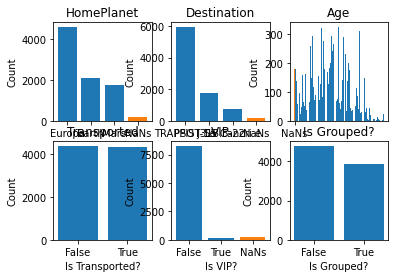

In [21]:
plt.figure()

plt.subplot(2,3,1)
plt.bar(train_df["HomePlanet"].dropna().unique(),train_df["HomePlanet"].value_counts())
plt.bar("NaNs",train_df["HomePlanet"].isna().sum())
plt.title("HomePlanet")
plt.xlabel("Origin")
plt.ylabel("Count")

plt.subplot(2,3,2)
plt.bar(train_df["Destination"].dropna().unique(),train_df["Destination"].value_counts())
plt.bar("NaNs",train_df["Destination"].isna().sum())
plt.title("Destination")
plt.xlabel("Destination")
plt.ylabel("Count")

plt.subplot(2,3,3)
plt.bar(train_df["Age"].dropna().unique(),train_df["Age"].value_counts())
plt.bar("NaNs",train_df["Age"].isna().sum())
plt.title("Age")
plt.xlabel("Age")
plt.ylabel("Count")

plt.subplot(2,3,4)
plt.bar(["False","True"],train_df["Transported"].value_counts())
plt.title("Transported")
plt.ylabel("Count")
plt.xlabel("Is Transported?")

plt.subplot(2,3,5)
plt.bar(["False","True"],train_df["VIP"].value_counts())
plt.bar("NaNs",train_df["VIP"].isna().sum())
plt.title("VIP")
plt.ylabel("Count")
plt.xlabel("Is VIP?")

plt.subplot(2,3,6)
plt.bar(["False","True"],train_df["IsGrouped"].value_counts())
plt.title("Is Grouped?")
plt.ylabel("Count")
plt.xlabel("Is Grouped?")

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

**How much NaNs do we have?**

**Fill NaNs:

If a person is on CryoSleep, can spend some money? Obviously no, so we are gonna fill "RoomService", "FoodCourt", "ShoppingMall", "Spa" and "VRDeck" NaNs with 0 when "CryoSleep is True (Sleeping).

When CryoSleep is False (Awake) we are gonna fill the NaNs with the mean of each column, assuming that a "awake" person may spend some money in the journey.

We are going to suposse that the NaNs values exists because of the "colision" with the space-time anomaly.

In [22]:
train_df.isna().sum()

PassengerId             0
HomePlanet            201
CryoSleep             217
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
dtype: int64

In [23]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#Fill spend_columns with 0 when cryosleep is True

for x in train_df[bill_columns].columns:
    aux = 0
    for a in train_df[x]:
        if train_df["CryoSleep"][aux] == True and np.isnan(a):
            train_df[x][aux] = 0
        aux += 1

for x in test_df[bill_columns].columns:
    aux = 0
    for a in test_df[x]:
        if test_df["CryoSleep"][aux] == True and np.isnan(a):
            test_df[x][aux] = 0
        aux += 1

**We filled all the NaNs when CryoSleep is True, but we have some NaNs in CryoSleep, so we are gonna fill them with True if all the "spend" columns are 0.**

In [24]:
def fill_cryosleep_true():
    bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for x in train_df[bill_columns].columns:
        aux = 0
        for a in train_df[x]:
            if np.isnan(train_df["CryoSleep"][aux]) and (train_df["RoomService"][aux]
                                                      +train_df["FoodCourt"][aux]
                                                      +train_df["ShoppingMall"][aux]
                                                      +train_df["Spa"][aux]
                                                      +train_df["VRDeck"][aux])== 0:
                train_df["CryoSleep"][aux] = True
            aux += 1

    for x in test_df[bill_columns].columns:
        aux = 0
        for a in test_df[x]:
            if np.isnan(test_df["CryoSleep"][aux]) and (test_df["RoomService"][aux]
                                                      +test_df["FoodCourt"][aux]
                                                      +test_df["ShoppingMall"][aux]
                                                      +test_df["Spa"][aux]
                                                      +test_df["VRDeck"][aux])== 0:
                test_df["CryoSleep"][aux] = True
            aux += 1
            
fill_cryosleep_true()            

**Now, if a person spend some in different services, should not be sleep. So, every NaN CryoSleep where the person have spent will become False.**

In [25]:
def fill_cryosleep_false():
    bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for x in train_df[bill_columns].columns:
        aux = 0
        for a in train_df[x]:
            if np.isnan(train_df["CryoSleep"][aux]) and (train_df["RoomService"][aux]
                                                      +train_df["FoodCourt"][aux]
                                                      +train_df["ShoppingMall"][aux]
                                                      +train_df["Spa"][aux]
                                                      +train_df["VRDeck"][aux])> 0:
                train_df["CryoSleep"][aux] = False
            aux += 1

    for x in test_df[bill_columns].columns:
        aux = 0
        for a in test_df[x]:
            if np.isnan(test_df["CryoSleep"][aux]) and (test_df["RoomService"][aux]
                                                      +test_df["FoodCourt"][aux]
                                                      +test_df["ShoppingMall"][aux]
                                                      +test_df["Spa"][aux]
                                                      +test_df["VRDeck"][aux])> 0:
                test_df["CryoSleep"][aux] = False
            aux += 1
            

In [26]:
train_df[(train_df["CryoSleep"] != False) & (train_df["CryoSleep"] != True)].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False,Carry,Cleachrand,0105,01,False,1
104,0110_02,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,Aldeba Bootious,False,Aldeba,Bootious,0110,02,True,4
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True,Rohs,Pead,0115,01,False,1
152,0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,Hilip Grifford,True,Hilip,Grifford,0173,01,False,1
224,0241_01,Europa,NaN,E/11/P,55 Cancri e,33.0,False,0.0,1249.0,0.0,4812.0,1116.0,Alas Dischod,False,Alas,Dischod,0241,01,False,1


**Now we have CryoSleep NaN & spend_columns NaN.**

1. If there is no other spent money in columns we are gonna fill the NaN with 0.

2. If there is a spend money in columns we are gonna fill the NaN with the mean.

**Then we are going to repet the CryoSleep NaNs filling if there is spent money or not**

In [27]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa','VRDeck']

for i in np.arange(len(train_df)):
    aux = 0
    
    for a in train_df[bill_columns].columns:
        if not np.isnan(train_df[a][i]):
            aux = aux + train_df[a][i]
            
    for b in train_df[bill_columns].columns:
        if np.isnan(train_df[b][i]) and aux > 0.0:
            train_df[b][i] = train_df[b].mean()
            
    for c in train_df[bill_columns].columns:
        if np.isnan(train_df[c][i]) and aux == 0.0:
            train_df[c][i] = 0

In [28]:
for i in np.arange(len(test_df)):
    aux = 0
    
    for a in test_df[bill_columns].columns:
        if not np.isnan(test_df[a][i]):
            aux = aux + test_df[a][i]
            
    for b in test_df[bill_columns].columns:
        if np.isnan(test_df[b][i]) and aux > 0.0:
            test_df[b][i] = test_df[b].mean()
            
    for c in test_df[bill_columns].columns:
        if np.isnan(test_df[c][i]) and aux == 0.0:
            test_df[c][i] = 0

**Add column TotalSpent**

In [29]:
train_df['TotalSpent'] = train_df['RoomService'] + train_df['FoodCourt'] + train_df['ShoppingMall'] + train_df['Spa'] + train_df['VRDeck']
test_df['TotalSpent'] = test_df['RoomService'] + test_df['FoodCourt'] + test_df['ShoppingMall'] + test_df['Spa'] + test_df['VRDeck']


**CONTINUE to clean the DataFrame. Imputer help us to get rid of NaNs**

In [30]:
fill_cryosleep_true()
fill_cryosleep_false()
train_df.isna().sum()

PassengerId             0
HomePlanet            201
CryoSleep               0
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
TotalSpent              0
dtype: int64

**Split Cabin deck/num/side in three different columns**

In [31]:
# Split Cabin deck/num/side in three different columns

train_df[['Deck', 'Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck', 'Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)

train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)

**Check the VIP nans**

If there is 0 TotalSpent then is no VIP. C'mon!

In [32]:
for i in np.arange(len(train_df)):
    if isNaN(train_df["VIP"][i]) and train_df["TotalSpent"][i] == 0:
        train_df["VIP"][i] = False
        
for i in np.arange(len(test_df)):
    if isNaN(test_df["VIP"][i]) and test_df["TotalSpent"][i] == 0:
        test_df["VIP"][i] = False

**if there is more o equal TotalSpent than true VIPS Spent, then, is VIP.**

In [33]:
train_df["TotalSpent"][train_df["VIP"]==True].mean()

4449.797337001945

In [34]:
for i in np.arange(len(train_df)):
    if isNaN(train_df["VIP"][i]) and (train_df["TotalSpent"][i] >= (train_df["TotalSpent"][train_df["VIP"]==True].mean())):
        train_df["VIP"][i] = True
        
for i in np.arange(len(test_df)):
    if isNaN(test_df["VIP"][i]) and (test_df["TotalSpent"][i] >= (test_df["TotalSpent"][test_df["VIP"]==True].mean())):
        test_df["VIP"][i] = True

**Change "object" type to category for further management. Floats to Integers**

In [35]:
train_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = train_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')
#train_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = train_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')
train_df[['CryoSleep', 'VIP']] = train_df[['CryoSleep', 'VIP']].astype('bool')

test_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = test_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')
#test_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = test_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')
test_df[['CryoSleep', 'VIP']] = test_df[['CryoSleep', 'VIP']].astype('bool')


**Now take a look on HomePlanet NaNs**

**We are going to fill "HomePlanet" NaNs of Grouped tickets with the HomePlanet of their roommates**

In [36]:
aux = 0
for i in np.arange(len(train_df)):
    
    if isNaN(train_df["HomePlanet"][i]) and train_df["IsGrouped"][i] == True:
        
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
            train_df["HomePlanet"][i] = train_df["HomePlanet"][i+1]
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
            train_df["HomePlanet"][i] = train_df["HomePlanet"][i-1]
  

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["HomePlanet"][i]) and test_df["IsGrouped"][i] == True:
        
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
            test_df["HomePlanet"][i] = train_df["HomePlanet"][i+1]
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
            test_df["HomePlanet"][i] = test_df["HomePlanet"][i-1]

In [37]:
train_df["Deck"].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

**Earth's people don't travel on B, C, D, A or T Deck**

**Mar's people don't travel on T, A, C, B, or G Deck**

**Europa's people don't travel on F, G Deck**

**Lasts HomePlanet NaNs are going to be filled by random assign a planet by the Deck selected**

### **THIS ONLY APPLY ON TRAIN DATAFRAME but we are going to fill the same in test df**

In [38]:
F_Deck = ["Earth","Mars"]
G_Deck = ["Earth"]
E_Deck = ["Earth","Mars","Europa"]
B_Deck = C_Deck = A_Deck = T_Deck = ["Europa"]
D_Deck = ["Mars","Europa"]


def check_deck(string):
    if string == "F":
        return F_Deck
    elif string == "G":
        return G_Deck
    elif string == "E":
        return E_Deck
    elif string == "B" or string == "C" or string == "T" or string == "A":
        return B_Deck
    elif string == "D":
        return D_Deck

for i in np.arange(len(train_df)):
    
    if isNaN(train_df["HomePlanet"][i]) and isNaN(train_df["Deck"][i]) == False:
        train_df["HomePlanet"][i] = random.choice(check_deck(train_df["Deck"][i]))

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["HomePlanet"][i]) and isNaN(test_df["Deck"][i]) == False:
        test_df["HomePlanet"][i] = random.choice(check_deck(test_df["Deck"][i]))

In [39]:
train_df.isna().sum()

PassengerId             0
HomePlanet              4
CryoSleep               0
Destination           182
Age                   179
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
TotalSpent              0
Deck                  199
Num                   199
Side                  199
dtype: int64

**Just 4 HomePlanets. We are coming back for them later.**

**Let's see Destination**

In [40]:
train_df[train_df["Destination"].isnull()].head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size,TotalSpent,Deck,Num,Side
47,0045_02,Mars,True,NaN,19.0,False,0.0,0.0,0.0,0.0,...,Mass,Chmad,0045,02,True,2,0.0,F,10,P
128,0138_02,Earth,False,NaN,34.0,False,0.0,22.0,0.0,564.0,...,Monah,Gambs,0138,02,True,2,793.0,E,5,P
139,0152_01,Earth,False,NaN,41.0,False,0.0,0.0,0.0,0.0,...,Andan,Estron,0152,01,False,1,607.0,F,32,P
347,0382_01,Earth,False,NaN,23.0,False,348.0,0.0,0.0,4.0,...,Blanie,Floydendley,0382,01,False,1,720.0,G,64,P
430,0462_01,Earth,True,NaN,50.0,False,0.0,0.0,0.0,0.0,...,Ronia,Sosanturney,0462,01,False,1,0.0,G,67,S


**Same threatment of HomePlanet. Let's see the destination of their roommates**

In [41]:

for i in np.arange(len(train_df)):
    
    if isNaN(train_df["Destination"][i]) and train_df["IsGrouped"][i] == True:
        
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
            train_df["Destination"][i] = train_df["Destination"][i+1]
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
            train_df["Destination"][i] = train_df["Destination"][i-1]
  

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["Destination"][i]) and test_df["IsGrouped"][i] == True:
        
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
            test_df["Destination"][i] = train_df["Destination"][i+1]
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
            test_df["Destination"][i] = test_df["Destination"][i-1]

**The rest NaNs of Destination are going to be filled by the probability from their HomePlanet**

In [42]:
t_from_mars = len(train_df[train_df["HomePlanet"] == "Mars"])
m_to_trappist = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "TRAPPIST-1e")])
m_to_cancri = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "55 Cancri e")])
m_to_pso = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "PSO J318.5-22")])

t_from_earth = len(train_df[train_df["HomePlanet"] == "Earth"])
e_to_trappist = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "TRAPPIST-1e")])
e_to_cancri = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "55 Cancri e")])
e_to_pso = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "PSO J318.5-22")])

t_from_europa = len(train_df[train_df["HomePlanet"] == "Europa"])
eu_to_trappist = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "TRAPPIST-1e")])
eu_to_cancri = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "55 Cancri e")])
eu_to_pso = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "PSO J318.5-22")])


In [43]:
def check_destination(homeplanet):
    if homeplanet == "Mars":
        i = np.random.random()
        if i <= m_to_trappist/t_from_mars:
            return "TRAPPIST-1e"
        elif i > m_to_trappist/t_from_mars and i <= (m_to_trappist/t_from_mars)+(m_to_cancri/t_from_mars):
            return "55 Cancri e"
        elif i > 1-m_to_cancri/t_from_mars:
            return "PSO J318.5-22"
        
    if homeplanet == "Earth":
        i = np.random.random()
        if i <= e_to_trappist/t_from_earth:
            return "TRAPPIST-1e"
        elif i > e_to_trappist/t_from_earth and i <= (e_to_trappist/t_from_earth)+(e_to_pso/t_from_earth):
            return "55 Cancri e"
        elif i > 1-e_to_pso/t_from_earth:
            return "PSO J318.5-22"

    if homeplanet == "Europa":
        i = np.random.random()
        if i <= eu_to_trappist/t_from_europa:
            return "TRAPPIST-1e"
        elif i > eu_to_trappist/t_from_europa and i <= (eu_to_trappist/t_from_europa)+(eu_to_cancri/t_from_europa):
            return "55 Cancri e"
        elif i > 1-eu_to_cancri/t_from_europa:
            return "PSO J318.5-22"

In [44]:
for i in np.arange(len(train_df)):
    if isNaN(train_df["Destination"][i]):
        train_df["Destination"][i] = check_destination(train_df["HomePlanet"][i])
        

In [45]:
t_from_mars = len(test_df[test_df["HomePlanet"] == "Mars"])
m_to_trappist = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "TRAPPIST-1e")])
m_to_cancri = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "55 Cancri e")])
m_to_pso = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "PSO J318.5-22")])

t_from_earth = len(test_df[test_df["HomePlanet"] == "Earth"])
e_to_trappist = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "TRAPPIST-1e")])
e_to_cancri = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "55 Cancri e")])
e_to_pso = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "PSO J318.5-22")])

t_from_europa = len(test_df[test_df["HomePlanet"] == "Europa"])
eu_to_trappist = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "TRAPPIST-1e")])
eu_to_cancri = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "55 Cancri e")])
eu_to_pso = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "PSO J318.5-22")])

In [46]:
for i in np.arange(len(test_df)):
    if isNaN(test_df["Destination"][i]):
        test_df["Destination"][i] = check_destination(test_df["HomePlanet"][i])

In [47]:
train_df.isna().sum()

PassengerId             0
HomePlanet              4
CryoSleep               0
Destination             1
Age                   179
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
TotalSpent              0
Deck                  199
Num                   199
Side                  199
dtype: int64

**Lets see Age**

**Can't really see a pattern in Age, Im gonna fill Age with the mean**

In [48]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace=True)
test_df["Age"].fillna(test_df["Age"].mean(), inplace=True)

**Create a Columns:**
1. IsAdult > 18 years <40
2. IsMiddleAge >= 40 < 60 years
3. IsOldAdult >= 60

In [49]:
train_df[['IsAdult','IsMiddleAge', 'IsOldAdult']]=True
train_df.loc[train_df['Age']<18, ['IsAdult', 'IsMiddleAge', 'IsOldAdult']]=False
train_df.loc[(train_df['Age']>=18)&(train_df['Age']<40), ['IsMiddleAge', 'IsOldAdult']]=False
train_df.loc[(train_df['Age']>=40)&(train_df['Age']<60), ['IsAdult', 'IsOldAdult']]=False
train_df.loc[(train_df['Age']>=60), ['IsAdult', 'IsMiddleAge']]=False

test_df[['IsAdult','IsMiddleAge', 'IsOldAdult']]=True
test_df.loc[test_df['Age']<18, ['IsAdult', 'IsMiddleAge', 'IsOldAdult']]=False
test_df.loc[(test_df['Age']>=18)&(test_df['Age']<40), ['IsMiddleAge', 'IsOldAdult']]=False
test_df.loc[(test_df['Age']>=40)&(test_df['Age']<60), ['IsAdult', 'IsOldAdult']]=False
test_df.loc[(test_df['Age']>=60), ['IsAdult', 'IsMiddleAge']]=False

**For this time im going to drop the Name**

In [50]:
train_df = train_df.drop('Name', axis=1)
test_df = test_df.drop('Name', axis=1)

In [51]:
train_df.isna().sum()

PassengerId             0
HomePlanet              4
CryoSleep               0
Destination             1
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
TotalSpent              0
Deck                  199
Num                   199
Side                  199
IsAdult                 0
IsMiddleAge             0
IsOldAdult              0
dtype: int64

**Fill Deck, Num and Side with their roommates**

In [52]:
fill_aux = ["Deck","Num","Side"]
for i in np.arange(len(train_df)):
    for a in fill_aux: 
        if isNaN(train_df[a][i]) and train_df["IsGrouped"][i] == True:

            if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
                train_df[a][i] = train_df[a][i+1]
            if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
                train_df[a][i] = train_df[a][i-1]
                
for i in np.arange(len(test_df)):
    for a in fill_aux: 
        if isNaN(test_df[a][i]) and test_df["IsGrouped"][i] == True:

            if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
                test_df[a][i] = test_df[a][i+1]
            if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
                test_df[a][i] = test_df[a][i-1]

In [53]:
train_df[train_df["Deck"].isna()]

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,PassengerId_Unique,IsGrouped,Group_Size,TotalSpent,Deck,Num,Side,IsAdult,IsMiddleAge,IsOldAdult
15,0012_01,Earth,False,TRAPPIST-1e,31.0,False,32.000000,0.0,876.0,0.0,...,01,False,1,908.000000,NaN,NaN,NaN,True,False,False
93,0101_01,Mars,True,TRAPPIST-1e,31.0,False,0.000000,0.0,0.0,0.0,...,01,False,1,0.000000,NaN,NaN,NaN,True,False,False
222,0239_01,Mars,False,TRAPPIST-1e,37.0,False,637.000000,0.0,0.0,92.0,...,01,False,1,1048.000000,NaN,NaN,NaN,True,False,False
272,0301_01,Earth,True,TRAPPIST-1e,16.0,False,0.000000,0.0,0.0,0.0,...,01,False,1,0.000000,NaN,NaN,NaN,False,False,False
280,0310_01,Europa,False,TRAPPIST-1e,67.0,False,222.906876,230.0,0.0,4476.0,...,01,False,1,5169.906876,NaN,NaN,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7847,8375_01,Earth,False,PSO J318.5-22,15.0,False,64.000000,0.0,0.0,0.0,...,01,False,1,704.000000,NaN,NaN,NaN,False,False,False
7899,8437_01,Earth,False,PSO J318.5-22,36.0,False,52.000000,0.0,132.0,334.0,...,01,False,1,694.000000,NaN,NaN,NaN,True,False,False
8039,8603_01,Earth,True,PSO J318.5-22,18.0,False,0.000000,0.0,0.0,0.0,...,01,False,1,0.000000,NaN,NaN,NaN,True,False,False
8066,8623_01,Earth,False,TRAPPIST-1e,15.0,False,9.000000,731.0,85.0,0.0,...,01,False,1,1362.000000,NaN,NaN,NaN,False,False,False


**ffill the last HomePlanet f%"#&"%ng NaNs remaining (4 in train 1 in test)**

In [54]:
train_df["HomePlanet"].fillna(method="ffill", inplace=True)

test_df["HomePlanet"].fillna(method="ffill", inplace=True)

**Fill the gaps randomly according to the deck used by each homeplanet**

In [55]:
Earth_Decks = ["F","G","E"]
Mars_Decks = ["F","E","D"]
Europas_Decks = ["E","B","C","A","T","D"]

def check_homeplanet(string):
    if string == "Earth":
        return Earth_Decks
    elif string == "Mars":
        return Mars_Decks
    elif string == "Europa":
        return Europas_Decks

for i in np.arange(len(train_df)):
    
    if isNaN(train_df["Deck"][i]):
        train_df["Deck"][i] = random.choice(check_homeplanet(train_df["HomePlanet"][i]))

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["Deck"][i]):
        test_df["Deck"][i] = random.choice(check_homeplanet(test_df["HomePlanet"][i]))

**Num: I will pick up the max Num and check for the free cabins. So I assign Num-Nans a freee cabin between the min a max num**

**Update: There is no free cabins hahaha so I assigned a new cabin not used before for each NaN**

In [56]:
#1894 max value in train df
max_value = 1894 + 1
for i in np.arange(len(train_df)):
    if isNaN(train_df["Num"][i]):
        train_df["Num"][i] = max_value
        max_value = max_value + 1

#1503 max value in test df

max_value = 1503 + 1
for i in np.arange(len(test_df)):
    if isNaN(test_df["Num"][i]):
        test_df["Num"][i] = max_value
        max_value = max_value + 1
        


**Finally (I hope so) Side will be filled randomly**

In [57]:
Sides = ["S","P"]
for i in np.arange(len(train_df)):
    if isNaN(train_df["Side"][i]):
        train_df["Side"][i] = random.choice(Sides)

        
for i in np.arange(len(test_df)):
    if isNaN(test_df["Side"][i]):
        test_df["Side"][i] = random.choice(Sides)

In [58]:
train_df.isna().sum()

PassengerId             0
HomePlanet              0
CryoSleep               0
Destination             1
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported             0
F_Name                200
L_Name                200
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Group_Size              0
TotalSpent              0
Deck                    0
Num                     0
Side                    0
IsAdult                 0
IsMiddleAge             0
IsOldAdult              0
dtype: int64

In [59]:
test_df.isna().sum()

PassengerId            0
HomePlanet             0
CryoSleep              0
Destination            0
Age                    0
VIP                    0
RoomService            0
FoodCourt              0
ShoppingMall           0
Spa                    0
VRDeck                 0
F_Name                94
L_Name                94
PassengerId_Ticket     0
PassengerId_Unique     0
IsGrouped              0
Group_Size             0
TotalSpent             0
Deck                   0
Num                    0
Side                   0
IsAdult                0
IsMiddleAge            0
IsOldAdult             0
dtype: int64

# FINALLY NO NANS

**Change object to categorycal for further labeling and management**

In [60]:
train_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = train_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')

test_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = test_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')

In [ ]:
plt.figure()
plt.rcParams["figure.figsize"] = (15,10)

plt.subplot(1,3,1)
plt.bar(train_df["HomePlanet"].unique(),train_df["HomePlanet"][(train_df["Transported"] == True)].value_counts(), color="red", label="Transported")
plt.bar(train_df["HomePlanet"].unique(),train_df["HomePlanet"][(train_df["Transported"] == False)].value_counts(), color="blue",label="Not Transported", width=0.5)
plt.xlabel("HomePlanet")
plt.legend()

plt.subplot(1,3,2)
plt.bar(train_df["Destination"].unique(),train_df["Destination"][(train_df["Transported"] == True)].value_counts(), color="red", label="Transported")
plt.bar(train_df["Destination"].unique(),train_df["Destination"][(train_df["Transported"] == False)].value_counts(), label="Not Transported", width=0.5)
plt.xlabel("Destination")
plt.legend()

plt.subplot(1,3,3)
plt.bar(train_df["CryoSleep"].unique(),train_df["CryoSleep"][(train_df["Transported"] == True)].value_counts(), color="red", label="Transported")
plt.bar(train_df["CryoSleep"].unique(),train_df["CryoSleep"][(train_df["Transported"] == False)].value_counts(), label="Not Transported", width=0.5)
plt.xlabel("CryoSleep")
plt.legend()

plt.legend()

plt.show()

In [63]:
train_df.head().style.background_gradient(cmap="Blues")

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,F_Name,L_Name,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size,TotalSpent,Deck,Num,Side,IsAdult,IsMiddleAge,IsOldAdult
0,0001_01,Europa,False,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,Maham,Ofracculy,1,1,False,1,0.000000,B,0,P,True,False,False
1,0002_01,Earth,False,TRAPPIST-1e,24.000000,False,109.000000,9.000000,25.000000,549.000000,44.000000,True,Juanna,Vines,2,1,False,1,736.000000,F,0,S,True,False,False
2,0003_01,Europa,False,TRAPPIST-1e,58.000000,True,43.000000,3576.000000,0.000000,6715.000000,49.000000,False,Altark,Susent,3,1,True,2,10383.000000,A,0,S,False,True,False
3,0003_02,Europa,False,TRAPPIST-1e,33.000000,False,0.000000,1283.000000,371.000000,3329.000000,193.000000,False,Solam,Susent,3,2,True,2,5176.000000,A,0,S,True,False,False
4,0004_01,Earth,False,TRAPPIST-1e,16.000000,False,303.000000,70.000000,151.000000,565.000000,2.000000,True,Willy,Santantines,4,1,False,1,1091.000000,F,1,S,False,False,False


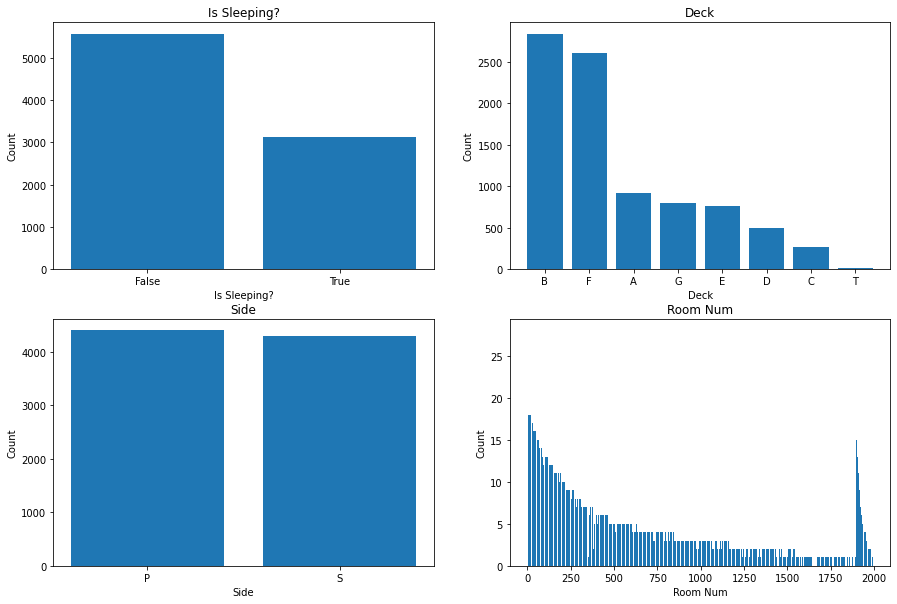

In [65]:
plt.figure()

plt.subplot(2,2,1)
plt.bar(["False","True"],train_df["CryoSleep"].value_counts())
plt.title("Is Sleeping?")
plt.ylabel("Count")
plt.xlabel("Is Sleeping?")

plt.subplot(2,2,2)
plt.bar(train_df["Deck"].dropna().unique(),train_df["Deck"].value_counts())
plt.title("Deck")
plt.xlabel("Deck")
plt.ylabel("Count")

plt.subplot(2,2,3)
plt.bar(train_df["Side"].dropna().unique(),train_df["Side"].value_counts())
plt.title("Side")
plt.xlabel("Side")
plt.ylabel("Count")

plt.subplot(2,2,4)
plt.bar(train_df["Num"].unique(),train_df["Num"].value_counts())
plt.title("Room Num")
plt.xlabel("Room Num")
plt.ylabel("Count")

plt.show()

**Label categorical data to standarize everything (Deck, Side).**

In [66]:
label_encoder = LabelEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='category':
        train_df[i]=label_encoder.fit_transform(train_df[i])

for i in list(test_df.columns):
    if test_df[i].dtype=='category':
        test_df[i]=label_encoder.fit_transform(test_df[i])

In [ ]:
train_df.info()

In [ ]:
train_df.head()

**Here we make scaler to adjust the numeric data**

In [67]:
mask = ['HomePlanet','Destination','Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerId_Ticket', 'PassengerId_Unique', 'Deck', 'Num', 'Side', 'TotalSpent', 'Group_Size']
scaler = MinMaxScaler()

# Scale train df
scaler.fit(train_df[mask])
train_df[mask] = scaler.transform(train_df[mask])

# Scale test df
scaler.fit(test_df[mask])
test_df[mask] = scaler.transform(test_df[mask])

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,PassengerId_Unique,IsGrouped,Group_Size,TotalSpent,Deck,Num,Side,IsAdult,IsMiddleAge,IsOldAdult
0,0001_01,0.5,False,0.666667,0.493671,False,0.000000,0.000000,0.000000,0.000000,...,0.000000,False,0.000000,0.000000,0.142857,0.000000,0.0,True,False,False
1,0002_01,0.0,False,0.666667,0.303797,False,0.007608,0.000302,0.001064,0.024500,...,0.000000,False,0.000000,0.020452,0.714286,0.000000,1.0,True,False,False
2,0003_01,0.5,False,0.666667,0.734177,True,0.003001,0.119948,0.000000,0.299670,...,0.000000,True,0.142857,0.288521,0.000000,0.000000,1.0,False,True,False
3,0003_02,0.5,False,0.666667,0.417722,False,0.000000,0.043035,0.015793,0.148563,...,0.142857,True,0.142857,0.143830,0.000000,0.000000,1.0,True,False,False
4,0004_01,0.0,False,0.666667,0.202532,False,0.021149,0.002348,0.006428,0.025214,...,0.000000,False,0.000000,0.030317,0.714286,0.000502,1.0,False,False,False


**Now transform bool data into 0 and 1s**

In [ ]:
ERROR!

In [68]:
onehot = OneHotEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='bool':
        train_df[i]=label_encoder.fit_transform(train_df[i])
        
for i in list(test_df.columns):
    if test_df[i].dtype=='bool':
        test_df[i]=label_encoder.fit_transform(test_df[i])

**Now we got just numericall data**
FINAL TRAIN DATA FRAME

In [ ]:
train_df.info()

In [69]:
train_df = train_df.drop('F_Name', axis=1)
test_df = test_df.drop('F_Name', axis=1)

In [70]:
train_df = train_df.drop('L_Name', axis=1)
test_df = test_df.drop('L_Name', axis=1)

In [ ]:
print error to stop the notebook in "Run All" :D

In [71]:
train_df.head(10).style.background_gradient(cmap="Blues")

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Group_Size,TotalSpent,Deck,Num,Side,IsAdult,IsMiddleAge,IsOldAdult
0,0001_01,0.500000,0,0.666667,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0.142857,0.000000,0.000000,1,0,0
1,0002_01,0.000000,0,0.666667,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,1,0.000108,0.000000,0,0.000000,0.020452,0.714286,0.000000,1.000000,1,0,0
2,0003_01,0.500000,0,0.666667,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,0,0.000216,0.000000,1,0.142857,0.288521,0.000000,0.000000,1.000000,0,1,0
3,0003_02,0.500000,0,0.666667,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,0,0.000216,0.142857,1,0.142857,0.143830,0.000000,0.000000,1.000000,1,0,0
4,0004_01,0.000000,0,0.666667,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,1,0.000323,0.000000,0,0.000000,0.030317,0.714286,0.000502,1.000000,0,0,0
5,0005_01,0.000000,0,0.333333,0.556962,0,0.000000,0.016201,0.000000,0.012986,0.000000,1,0.000431,0.000000,0,0.000000,0.021508,0.714286,0.000000,0.000000,0,1,0
6,0006_01,0.000000,0,0.666667,0.329114,0,0.002932,0.051622,0.000128,0.000000,0.000000,1,0.000539,0.000000,1,0.142857,0.044016,0.714286,0.001004,1.000000,1,0,0
7,0006_02,0.000000,1,0.666667,0.354430,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000539,0.142857,1,0.142857,0.000000,0.857143,0.000000,1.000000,1,0,0
8,0007_01,0.000000,0,0.666667,0.443038,0,0.000000,0.026331,0.000724,0.009639,0.000000,1,0.000647,0.000000,0,0.000000,0.028288,0.714286,0.001505,1.000000,1,0,0
9,0008_01,0.500000,1,0.000000,0.177215,0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000754,0.000000,1,0.285714,0.000000,0.142857,0.000502,0.000000,0,0,0


   #                                         **INIT TRAINING MODELS**

**Setting up the variables**

In [185]:
X = train_df.drop(['PassengerId', 'Transported'], axis=1)
y = train_df['Transported']

df_test = test_df.drop(['PassengerId'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

### CATBOOST

In [197]:
start_time = time.time()

print("*** STARTING TRAINING CATBOOST MODEL ***\n")

model = CatBoostClassifier(task_type="GPU", iterations=5000, verbose=False)

model.fit(X_train,y_train, use_best_model=True, eval_set=(X_test, y_test))

print("*** FINISHED TRAINING IN: ", (time.time()-start_time), " SECONDS ***\n")


*** STARTING TRAINING CATBOOST MODEL ***

*** FINISHED TRAINING IN:  164.97887420654297  SECONDS ***



In [198]:
model.feature_importances_

array([1.09719208e+01, 5.91542200e+00, 1.47705911e+00, 4.47373595e+00,
       2.41100063e-01, 5.13120678e+00, 7.28923589e+00, 3.68061567e+00,
       1.15411368e+01, 9.21688080e+00, 2.77870184e+00, 3.07890904e-01,
       5.88070527e-03, 3.73507176e-01, 1.22225947e+01, 1.11711366e+01,
       8.04415619e+00, 4.63604112e+00, 3.57297384e-01, 6.57907284e-02,
       9.86888617e-02])

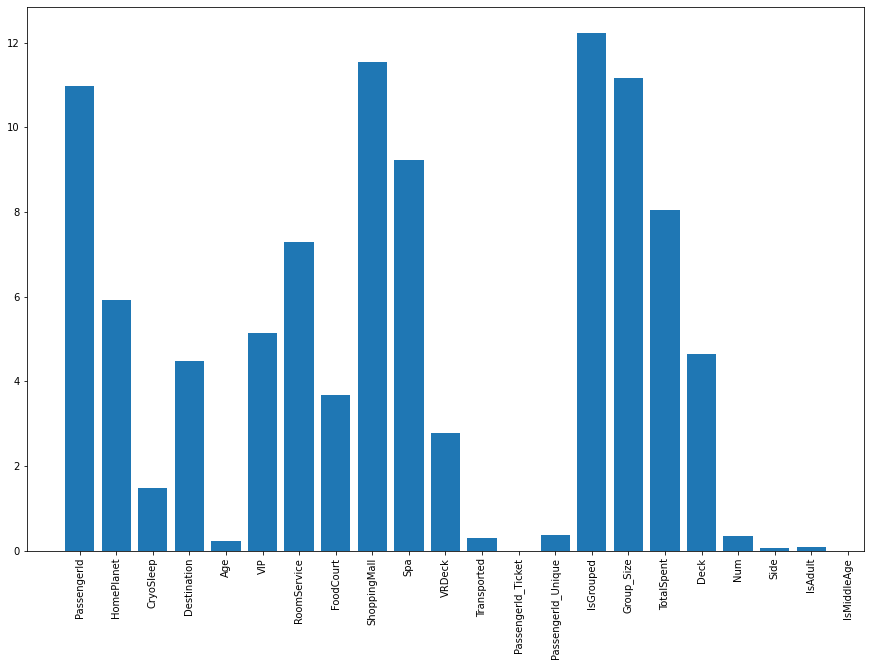

In [199]:
train_df.columns.array

asdf1 = pd.Series(model.feature_importances_)
asdf2 = pd.Series(train_df.columns.array)

dictxd = {"columnas": asdf2, "importancia": asdf1}
df55 = pd.DataFrame(dictxd)
plt.figure()
plt.bar(df55["columnas"].unique(),df55["importancia"])
plt.xticks(rotation=90)
plt.show()



In [200]:
CatPred = model.predict(X_test)

In [201]:
print("Performance on train data:", model.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, CatPred, average='micro'))

Performance on train data: 0.8579536738763615
Performance on validation data: 0.8045078196872126


In [202]:
CatPred = model.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': CatPred.astype('bool')})

output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2746
False    1531
Name: Transported, dtype: int64

In [203]:
output.to_csv("CatBoostClassifier_SubmissionV2.0.csv")

# LGBM Classifier

In [205]:
start_time = time.time()

gridParams = {
    'learning_rate': [0.001, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
  #  'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [42]
    }

clf = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = -1, 
          verbose = 0,
           device = "gpu")

grid = GridSearchCV(clf, gridParams, verbose=1, cv=4, n_jobs=-1)
grid.fit(X_train, y_train)

# Print the best parameters found
print('Best params: ', grid.best_params_)
print('Tuned LGBM best score {}'.format(grid.best_score_))
print('Tuned LGBM Forest best params {}'.format(grid.best_estimator_))
print('This took: ', (time.time()-start_time), " seconds.")

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Best params:  {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'n_estimators': 24, 'num_leaves': 16, 'objective': 'binary', 'random_state': 42}
Tuned LGBM best score 0.786165437036535
Tuned LGBM Forest best params LGBMClassifier(device='gpu', learning_rate=0.01, n_estimators=24, num_leaves=16,
               objective='binary', random_state=42, verbose=0)
This took:  38.9904203414917  seconds.


In [206]:
# predict the results
y_pred=grid.predict(X_test)

In [207]:
print("Performance on train data:", grid.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, y_pred, average='micro'))

Performance on train data: 0.7922994324282866
Performance on validation data: 0.7732290708371665


In [210]:
y_pred = grid.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': y_pred.astype('bool')})

output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2548
False    1729
Name: Transported, dtype: int64

In [211]:
output.to_csv("LGBMClassifier_SubmissionV4.0.csv")

## **XGB Classifier**

In [217]:
start_time = time.time()
xgb_model = xgb.XGBClassifier()

params = {"eval_metric": "logloss"}

modelxgb = xgb_model.fit(X_train2, y_train2, eval_metric='logloss')

print("\nThis took ", (time.time()-start_time), " seconds...")

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,



This took  0.873485803604126  seconds...


In [218]:
y_valid_pred = modelxgb.predict(X_test2)

In [219]:
print("Performance on train data:", modelxgb.score(X_train2, y_train2))
print("Performance on validation data:", f1_score(y_test2, y_valid_pred, average='micro'))

Performance on train data: 0.9536738763614051
Performance on validation data: 0.7948482060717571


**Create output DataFrame with prediction**

In [220]:
predicted_y = modelxgb.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': predicted_y.astype('bool')})

output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2248
False    2029
Name: Transported, dtype: int64

**Export Data for submission**

In [221]:
output.to_csv("XGBClassifier_SubmissionV4.0.csv")

## **Neural Network**

In [222]:
# 20 columnas x 8692 datos
# 20 columnas x 4276 datos
from sklearn.neural_network import MLPClassifier

start_time = time.time()

param_grid = [{'activation' : ['logistic'],'solver' : ['lbfgs'],'hidden_layer_sizes': [(26,),(36,),(46,)]}]

model = MLPClassifier(max_iter=30000)

clf = GridSearchCV(model, param_grid, cv=3,scoring='accuracy', n_jobs=-1)
clf.fit(X_train,y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print("\nMLPC Training model tooks: ", (time.time()-start_time), " seconds.")

Best parameters set found on development set:
{'activation': 'logistic', 'hidden_layer_sizes': (26,), 'solver': 'lbfgs'}
Accuracy of NN classifier on training set: 0.87

MLPC Training model tooks:  401.74687004089355  seconds.


In [223]:
mlpcresult = clf.predict(X_test)

In [224]:
print("Performance on train data:", clf.score(X_train2, y_train2))
print("Performance on validation data:", f1_score(y_test2, mlpcresult, average='micro'))

Performance on train data: 0.8740604387175948
Performance on validation data: 0.7727690892364305


In [225]:
mlpcresult2 = clf.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': mlpcresult2.astype('bool')})
#output["Transported"].value_counts()
output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2431
False    1846
Name: Transported, dtype: int64

In [226]:
output.to_csv("MPLCSubmissionV4.0.csv")

## **RandomForestClassifier**

In [227]:
#0.8764 minmaxscaler
#0.8758 standardscaler

start_time = time.time()

parameter_grid={'n_estimators':[50],'max_depth':[10,15,20]}

clf = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)

grid_model = GridSearchCV(clf, parameter_grid, cv=kfold,scoring='accuracy', n_jobs=-1)

grid_model.fit(X_train,y_train)

print("Best params",grid_model.best_params_)
print("Best score",grid_model.best_score_)

print("\nModel training took: ",(time.time()-start_time)," seconds")

Best params {'max_depth': 10, 'n_estimators': 50}
Best score 0.8042645575942627

Model training took:  8.928838968276978  seconds


In [230]:
rfresult = grid_model.predict(X_test)

In [231]:
print("Performance on train data:", grid_model.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, rfresult, average='micro'))

Performance on train data: 0.8909341923607915
Performance on validation data: 0.7930082796688133


**Now we can predict**

**Generate the submission DataFrame**

In [232]:
y_pred2 = grid_model.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': y_pred2.astype('bool')})
output["Transported"].value_counts()

# Score: 0.79798


True     2296
False    1981
Name: Transported, dtype: int64

**Save .csv file**

In [233]:
output.to_csv('RandomForestv4.0.csv', index=False)

# ENSEMBLED MODEL

In [237]:
Ensemble_HV = VotingClassifier(estimators= [('CATBOOST', model),
                                            ('LGBM', grid),
                                           ('XBG', modelxgb),
                                           ('MLPC', clf),
                                           ('RANDOMFOREST', grid_model)
                                           ],
                              voting = 'hard')

# Return Accuracy Scores
cv_HV = cross_val_score(Ensemble_HV, X, y, scoring='accuracy')

print('Hard Voting Classifier:' , cv_HV.mean())

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Hard Voting Classifier: 0.7591233669337628


In [238]:
ensemble_model = Ensemble_HV.fit(X, y)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


In [239]:
e_pred = ensemble_model.predict(X_test)

In [240]:
print("Performance on train data:", ensemble_model.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, e_pred, average='micro'))

Performance on train data: 0.9544408651633686
Performance on validation data: 0.9466421343146273


In [241]:
e_pred = ensemble_model.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': e_pred.astype('bool')})
output["Transported"].value_counts()

# Score: 0.79798

True     2315
False    1962
Name: Transported, dtype: int64

In [242]:
output.to_csv('Ensemble_Model_V1.0.csv', index=False)

Scores:

* EnsembleModel: 0.79448
* RandomForest: 0.79331
* XGB: 0.78489
* LGBM: 0.78115
* CatBoost: 0.77460
* MPLC: 0.73556


Try an Ensemble without MPLC and CatBoost

In [243]:
Ensemble_HV2 = VotingClassifier(estimators= [('LGBM', grid),
                                           ('XBG', modelxgb),
                                           ('RANDOMFOREST', grid_model)
                                           ],
                                voting = 'hard')

# Return Accuracy Scores
cv_HV2 = cross_val_score(Ensemble_HV2, X, y, scoring='accuracy')

print('Hard Voting Classifier:' , cv_HV2.mean())

Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Fitting 4 folds for each of 48 candidates, totalling 192 fits
Hard Voting Classifier: 0.7305989778922718


In [244]:
ensemble_model2 = Ensemble_HV2.fit(X, y)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


In [245]:
e_pred2 = ensemble_model2.predict(X_test)

In [246]:
print("Performance on train data:", ensemble_model2.score(X_train, y_train))
print("Performance on validation data:", f1_score(y_test, e_pred2, average='micro'))

Performance on train data: 0.9492253413100169
Performance on validation data: 0.9425022999080037


In [248]:
e_pred2 = ensemble_model2.predict(df_test)
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': e_pred2.astype('bool')})
output["Transported"].value_counts()

# Score: 0.79798

True     2316
False    1961
Name: Transported, dtype: int64

In [ ]:
output.to_csv('Ensemble_Model_V2.0.csv', index=False)